# Training MPS in different ways

Here we show different configurations for training MPS models. One can try
different combinations of initializations and embeddings to look for the best
model for a certain dataset.

With this code, one can reproduce the results from [[SS16']](https://arxiv.org/abs/1605.05775)
and [[NTO16']](https://arxiv.org/abs/1605.03795), although training is performed
by optimizing all MPS cores at the same time, in contrast with the DMRG-like
approach of the first reference.

In [ ]:
%mkdir data
%mkdir models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import tensorkrowch as tk

In [2]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

## Dataset

In [3]:
# MNIST Dataset
dataset_name = 'mnist'
batch_size = 64
image_size = 28
input_size = image_size ** 2
num_classes = 10

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(image_size, antialias=True),
                               ])

# Load data
train_dataset = datasets.MNIST(root='data/',
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = datasets.MNIST(root='data/',
                              train=False,
                              transform=transform,
                              download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

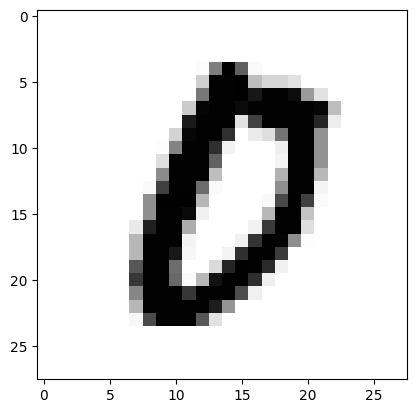

0


In [4]:
random_sample = torch.randint(low=0, high=len(train_dataset), size=(1,)).item()

plt.imshow(train_dataset[random_sample][0].squeeze(0), cmap='Greys')
plt.show()

print(train_dataset[random_sample][1])

## Instantiate MPS models

One can choose between different initialization schemes, as well as different
contraction options.

In [5]:
# Model hyperparameters
embedding_dim = 3
output_dim = num_classes
bond_dim = 10
init_method = 'randn_eye' # rand, randn, randn_eye, canonical, unit

# Contraction options
inline_input = False
inline_mats = False
renormalize = False

In [6]:
# Initialize network
model_name = 'mps'
mps = tk.models.MPSLayer(n_features=input_size + 1,
                         in_dim=embedding_dim,
                         out_dim=num_classes,
                         bond_dim=bond_dim,
                         boundary='obc',
                         init_method=init_method,
                         std=1e-6,  # This can be changed or ignored
                         device=device)

Choose an embedding, which may depend on the choice of the `init_method`:

In [7]:
def embedding(x):
    x = tk.embeddings.poly(x, degree=embedding_dim - 1)
    return x

In [9]:
def embedding(x):
    x = tk.embeddings.unit(x, dim=embedding_dim)
    return x

In [ ]:
def embedding(x):
    x = tk.embeddings.discretize(x, base=embedding_dim, level=1).squeeze(-1).int()
    x = tk.embeddings.basis(x, dim=embedding_dim).float() # batch x n_features x dim
    return x

## Train

In [8]:
# Trace the model to accelerate training
mps.trace(torch.zeros(1, input_size, embedding_dim, device=device),
          inline_input=inline_input,
          inline_mats=inline_mats,
          renormalize=renormalize)

In [9]:
# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mps.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

In [10]:
# Check accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(embedding(x),
                           inline_input=inline_input,
                           inline_mats=inline_mats,
                           renormalize=renormalize)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        accuracy = float(num_correct) / float(num_samples) * 100
    model.train()
    return accuracy

In [11]:
# Train network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        
        # Forward
        scores = mps(embedding(data),
                     inline_input=inline_input,
                     inline_mats=inline_mats,
                     renormalize=renormalize)
        loss = criterion(scores, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = check_accuracy(train_loader, mps)
    test_acc = check_accuracy(test_loader, mps)
    
    print(f'* Epoch {epoch + 1:<3} => Train. Acc.: {train_acc:.2f},'
          f' Test Acc.: {test_acc:.2f}')

# Reset before saving the model
mps.reset()
torch.save(mps.state_dict(), f'models/{model_name}_{dataset_name}.pt')

* Epoch 1   => Train. Acc.: 92.03, Test Acc.: 91.79
* Epoch 2   => Train. Acc.: 96.01, Test Acc.: 95.74
* Epoch 3   => Train. Acc.: 97.52, Test Acc.: 97.12
* Epoch 4   => Train. Acc.: 97.93, Test Acc.: 97.55
* Epoch 5   => Train. Acc.: 97.67, Test Acc.: 96.92
* Epoch 6   => Train. Acc.: 98.09, Test Acc.: 97.21
* Epoch 7   => Train. Acc.: 98.40, Test Acc.: 97.57
* Epoch 8   => Train. Acc.: 98.58, Test Acc.: 97.55
* Epoch 9   => Train. Acc.: 98.84, Test Acc.: 97.83
* Epoch 10  => Train. Acc.: 98.69, Test Acc.: 97.76


In [11]:
def n_params(model):
    n = 0
    for p in model.parameters():
        n += p.numel()
    return n

In [14]:
n = n_params(mps)
test_acc = check_accuracy(test_loader, mps)
test_acc, n

(97.76, 236220)

## Prune and retrain

In [15]:
# Load network
mps = tk.models.MPSLayer(n_features=input_size + 1,
                         in_dim=embedding_dim,
                         out_dim=num_classes,
                         bond_dim=bond_dim,
                         boundary='obc',
                         device=device)
mps.load_state_dict(torch.load(f'models/{model_name}_{dataset_name}.pt'))

<All keys matched successfully>

In [16]:
mps.canonicalize(cum_percentage=0.98, renormalize=True)

In [17]:
n = n_params(mps)
test_acc = check_accuracy(test_loader, mps)
test_acc, n

(93.4, 159962)

In [18]:
new_bond_dim = mps.bond_dim

# Contraction options
inline_input = False
inline_mats = True
renormalize = False

In [19]:
# Trace the model to accelerate training
mps.trace(torch.zeros(1, input_size, embedding_dim, device=device),
          inline_input=inline_input,
          inline_mats=inline_mats,
          renormalize=renormalize)

In [20]:
# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 1

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mps.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

In [21]:
# Train network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        
        # Forward
        scores = mps(embedding(data),
                     inline_input=inline_input,
                     inline_mats=inline_mats,
                     renormalize=renormalize)
        loss = criterion(scores, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = check_accuracy(train_loader, mps)
    test_acc = check_accuracy(test_loader, mps)
    
    print(f'* Epoch {epoch + 1:<3} => Train. Acc.: {train_acc:.2f},'
          f' Test Acc.: {test_acc:.2f}')

# Reset before saving the model
mps.reset()
# torch.save(mps.state_dict(), f'models/{model_name}_{dataset_name}.pt')

* Epoch 1   => Train. Acc.: 98.65, Test Acc.: 97.72


We can prune and retrain the model again, repeating the process until *convergence*.

In [22]:
mps.canonicalize(cum_percentage=0.98, renormalize=True)

In [23]:
n = n_params(mps)
test_acc = check_accuracy(test_loader, mps)
test_acc, n

(97.72, 159674)